In [2]:
import re
import math
import glob 
import chardet
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.gridspec import GridSpec

path = './finance_data/'

In [3]:
all_files = glob.glob(path + 'moex-IMOEX-*-marg-optionsdesk.csv')

In [4]:
with open(path + "moex-IMOEX-120325-marg-optionsdesk.csv", "rb") as f:
    result_encoding = chardet.detect(f.read())
    print(result_encoding["encoding"])

windows-1251


In [5]:
dfs = []

for filename in all_files:
    date_match = re.search(r'IMOEX-(\d{6})', filename)
    
    if date_match:
        date_str = date_match.group(1)
        
        #convertion date to format dd.mm.yyyy
        day = date_str[:2]
        month = date_str[2:4]
        year = '20' + date_str[4:6]
        
        formatted_date = f"{day}.{month}.{year}"
        
        df = pd.read_csv(filename, encoding = 'windows-1251')
        
        df['execution_date'] = formatted_date
        dfs.append(df)
        print(f"Processed {filename} with date {formatted_date}")


Processed ./finance_data\moex-IMOEX-120325-marg-optionsdesk.csv with date 12.03.2025
Processed ./finance_data\moex-IMOEX-150328-marg-optionsdesk.csv with date 15.03.2028
Processed ./finance_data\moex-IMOEX-150927-marg-optionsdesk.csv with date 15.09.2027
Processed ./finance_data\moex-IMOEX-151025-marg-optionsdesk.csv with date 15.10.2025
Processed ./finance_data\moex-IMOEX-151227-marg-optionsdesk.csv with date 15.12.2027
Processed ./finance_data\moex-IMOEX-160425-marg-optionsdesk.csv with date 16.04.2025
Processed ./finance_data\moex-IMOEX-160627-marg-optionsdesk.csv with date 16.06.2027
Processed ./finance_data\moex-IMOEX-170327-marg-optionsdesk.csv with date 17.03.2027
Processed ./finance_data\moex-IMOEX-170626-marg-optionsdesk.csv with date 17.06.2026
Processed ./finance_data\moex-IMOEX-180226-marg-optionsdesk.csv with date 18.02.2026
Processed ./finance_data\moex-IMOEX-180326-marg-optionsdesk.csv with date 18.03.2026
Processed ./finance_data\moex-IMOEX-180625-marg-optionsdesk.csv w

In [6]:
if dfs:
    combined_df = pd.concat(dfs, ignore_index=True)
    
    combined_df['execution_date_dt'] = pd.to_datetime(combined_df['execution_date'], format='%d.%m.%Y')
    
    combined_df = combined_df.sort_values('execution_date_dt')
    
    combined_df.to_csv('combined_moex_options.csv', encoding='utf-8', index=False)
    
    print(f"Combined {len(dfs)} files into 'combined_moex_options.csv'")
    print(f"Shape of combined dataframe: {combined_df.shape}")
    
    # to verify if needed
    # print(combined_df.head())
else:
    print("No matching files found.")

Combined 15 files into 'combined_moex_options.csv'
Shape of combined dataframe: (759, 46)


In [7]:
for filename in all_files:
    df = pd.read_csv(filename, encoding='windows-1251')
    
    for col in df.select_dtypes(include=[object]):
        df[col] = df[col].astype(str).str.encode('windows-1251', errors='ignore').str.decode('utf-8')
    
    dfs.append(df)

In [8]:
df_combined = pd.read_csv('combined_moex_options.csv', encoding='utf-8')

for i, col in enumerate(df_combined.columns):
    print(f"{i}: {col}")

0: CALL: Объем торгов, руб
1: CALL: Объем торгов, контр
2: CALL: Открыт.позиций
3: CALL: Последняя сделка, Значение
4: CALL: Последняя сделка, Дата
5: CALL: Последняя сделка, Изменение
6: CALL: ПОКУПКА
7: CALL: ПРОДАЖА
8: CALL: Расчетная цена
9: CALL: Теоретическая цена
10: СТРАЙК
11: IV
12: PUT: Теоретическая цена
13: PUT: Расчетная цена
14: PUT: ПОКУПКА
15: PUT: ПРОДАЖА
16: PUT: Последняя сделка, Значение
17: PUT: Последняя сделка, Дата
18: PUT: Последняя сделка, Изменение
19: PUT: Открыт. позиций
20: PUT: Объем торгов, руб
21: PUT: Объем торгов, контр
22: Unnamed: 22
23: execution_date
24: CALL: пїЅпїЅпїЅпїЅпїЅ пїЅпїЅпїЅпїЅпїЅпїЅ, пїЅпїЅпїЅ
25: CALL: пїЅпїЅпїЅпїЅпїЅ пїЅпїЅпїЅпїЅпїЅпїЅ, пїЅпїЅпїЅпїЅпїЅ
26: CALL: пїЅпїЅпїЅпїЅпїЅпїЅ.пїЅпїЅпїЅпїЅпїЅпїЅпїЅ
27: CALL: пїЅпїЅпїЅпїЅпїЅпїЅпїЅпїЅпїЅ пїЅпїЅпїЅпїЅпїЅпїЅ, пїЅпїЅпїЅпїЅпїЅпїЅпїЅпїЅ
28: CALL: пїЅпїЅпїЅпїЅпїЅпїЅпїЅпїЅпїЅ пїЅпїЅпїЅпїЅпїЅпїЅ, пїЅпїЅпїЅпїЅ
29: CALL: пїЅпїЅпїЅпїЅпїЅпїЅпїЅпїЅпїЅ пїЅпїЅпїЅпїЅпїЅпїЅ, пїЅпїЅпїЅпїЅпїЅпїЅпїЅпї

In [9]:
#clean corrupted columns
corrupted_cols = [col for col in df_combined.columns if '�' in str(col) or 'пїЅ' in str(col)]
df_combined = df_combined.drop(columns=corrupted_cols)
df_combined = df_combined.drop(columns=['Unnamed: 22', 'execution_date'])

df_combined.head(20)

,"CALL: Объем торгов, руб","CALL: Объем торгов, контр",CALL: Открыт.позиций,"CALL: Последняя сделка, Значение","CALL: Последняя сделка, Дата","CALL: Последняя сделка, Изменение",CALL: ПОКУПКА,CALL: ПРОДАЖА,CALL: Расчетная цена,CALL: Теоретическая цена,...,PUT: Расчетная цена,PUT: ПОКУПКА,PUT: ПРОДАЖА,"PUT: Последняя сделка, Значение","PUT: Последняя сделка, Дата","PUT: Последняя сделка, Изменение",PUT: Открыт. позиций,"PUT: Объем торгов, руб","PUT: Объем торгов, контр",execution_date_dt
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,369.08,330.42,...,0.02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-12
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.12,0.01,...,328.62,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-12
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.71,0.28,0.01,...,278.95,313.73,324.53,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-12
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.75,0.68,0.03,...,229.53,264.18,275.91,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-12
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.74,1.74,0.12,...,180.76,214.14,223.42,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-12
5,NaN,NaN,NaN,NaN,NaN,NaN,0.01,8.76,10.97,2.36,...,90.34,116.38,128.11,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-12
6,NaN,NaN,NaN,NaN,NaN,NaN,4.13,15.86,24.52,8.61,...,54.07,72.01,83.73,NaN,NaN,NaN,NaN,NaN,NaN,2025-03-12
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.21,4.47,0.56,...,133.67,166.52,178.24,118.37,07.03.25 17:18:56,NaN,100.0,167500.0,50.0,2025-03-12
8,NaN,NaN,NaN,NaN,NaN,NaN,46.23,57.96,82.47,51.12,...,12.37,15.84,27.57,NaN,NaN,NaN,100.0,NaN,NaN,2025-03-12
9,155000.0,50.0,100.0,136.70,07.03.25 17:18:54,NaN,79.21,90.89,124.74,88.81,...,4.81,2.36,13.78,NaN,NaN,NaN,100.0,NaN,NaN,2025-03-12


In [10]:
with open("combined_moex_options.csv", "rb") as f:
    result_en = chardet.detect(f.read())
    print(f"Detected encoding after saving: {result_en['encoding']}")

Detected encoding after saving: utf-8


In [11]:
#clean missing columns
missing_percentage = df_combined.isna().mean() * 100

for col, pct in missing_percentage.items():
    print(f"{col}: {pct:.2f}%")

target_value_of_missing = 96
columns_to_drop = missing_percentage[missing_percentage >= target_value_of_missing].index.tolist()

print(f"\nDropping {len(columns_to_drop)} columns with {target_value_of_missing}% or more missing values")

df_cleaned = df_combined.drop(columns=columns_to_drop)

df_cleaned.to_csv('cleaned_moex_options.csv', encoding='utf-8', index=False)

print(f"Original DataFrame shape: {df_combined.shape}")
print(f"Cleaned DataFrame shape: {df_cleaned.shape}")

CALL: Объем торгов, руб: 99.74%
CALL: Объем торгов, контр: 99.74%
CALL: Открыт.позиций: 93.68%
CALL: Последняя сделка, Значение: 99.74%
CALL: Последняя сделка, Дата: 99.74%
CALL: Последняя сделка, Изменение: 100.00%
CALL: ПОКУПКА: 96.05%
CALL: ПРОДАЖА: 95.52%
CALL: Расчетная цена: 8.04%
CALL: Теоретическая цена: 8.04%
СТРАЙК: 8.04%
IV: 0.00%
PUT: Теоретическая цена: 8.04%
PUT: Расчетная цена: 8.04%
PUT: ПОКУПКА: 95.78%
PUT: ПРОДАЖА: 95.52%
PUT: Последняя сделка, Значение: 99.47%
PUT: Последняя сделка, Дата: 99.47%
PUT: Последняя сделка, Изменение: 99.87%
PUT: Открыт. позиций: 97.76%
PUT: Объем торгов, руб: 99.47%
PUT: Объем торгов, контр: 99.47%
execution_date_dt: 0.00%

Dropping 12 columns with 96% or more missing values
Original DataFrame shape: (759, 23)
Cleaned DataFrame shape: (759, 11)


In [12]:
df_cleaned.head(10)

,CALL: Открыт.позиций,CALL: ПРОДАЖА,CALL: Расчетная цена,CALL: Теоретическая цена,СТРАЙК,IV,PUT: Теоретическая цена,PUT: Расчетная цена,PUT: ПОКУПКА,PUT: ПРОДАЖА,execution_date_dt
0,NaN,NaN,369.08,330.42,2850.0,30.04,0.03,0.02,NaN,NaN,2025-03-12
1,NaN,NaN,0.12,0.01,3550.0,24.66,367.57,328.62,NaN,NaN,2025-03-12
2,NaN,5.71,0.28,0.01,3500.0,23.52,317.72,278.95,313.73,324.53,2025-03-12
3,NaN,5.75,0.68,0.03,3450.0,22.54,267.88,229.53,264.18,275.91,2025-03-12
4,NaN,5.74,1.74,0.12,3400.0,21.76,218.12,180.76,214.14,223.42,2025-03-12
5,NaN,8.76,10.97,2.36,3300.0,20.92,120.66,90.34,116.38,128.11,2025-03-12
6,NaN,15.86,24.52,8.61,3250.0,21.17,77.05,54.07,72.01,83.73,2025-03-12
7,NaN,7.21,4.47,0.56,3350.0,21.20,168.70,133.67,166.52,178.24,2025-03-12
8,NaN,57.96,82.47,51.12,3150.0,22.46,19.85,12.37,15.84,27.57,2025-03-12
9,100.0,90.89,124.74,88.81,3100.0,23.11,7.68,4.81,2.36,13.78,2025-03-12


In [13]:
# математическое ожидание и стандартное отклонение для Расчтенной цены Call опциона
call_Settlement_price = 'CALL: Расчетная цена'
date_ex = 'execution_date_dt'
math_expectation = df_cleaned[call_Settlement_price].mean()
std_deviation = df_cleaned[call_Settlement_price].std()
print(f"\nМатематическое ожидание цены: {math_expectation:.2f}")
print(f"Стандартное отклонение цены (волатильность): {std_deviation:.2f}")


Математическое ожидание цены: 618.94
Стандартное отклонение цены (волатильность): 475.67


In [14]:
# Простейшая стратегия:
# Если цена ниже математического ожидания, считаем это сигналом для покупки ("Покупка").
# Если цена выше математического ожидания, сигнал для продажи ("Продажа").
def generate_signal(price):
    if price < math_expectation:
        return 'Покупка'
    elif price > math_expectation:
        return 'Продажа'
    else:
        return 'Нейтрально'
    
df_cleaned['Сигнал'] = df_cleaned[call_Settlement_price].apply(generate_signal)

df_cleaned.head(30)

,CALL: Открыт.позиций,CALL: ПРОДАЖА,CALL: Расчетная цена,CALL: Теоретическая цена,СТРАЙК,IV,PUT: Теоретическая цена,PUT: Расчетная цена,PUT: ПОКУПКА,PUT: ПРОДАЖА,execution_date_dt,Сигнал
0,NaN,NaN,369.08,330.42,2850.0,30.04,0.03,0.02,NaN,NaN,2025-03-12,Покупка
1,NaN,NaN,0.12,0.01,3550.0,24.66,367.57,328.62,NaN,NaN,2025-03-12,Покупка
2,NaN,5.71,0.28,0.01,3500.0,23.52,317.72,278.95,313.73,324.53,2025-03-12,Покупка
3,NaN,5.75,0.68,0.03,3450.0,22.54,267.88,229.53,264.18,275.91,2025-03-12,Покупка
4,NaN,5.74,1.74,0.12,3400.0,21.76,218.12,180.76,214.14,223.42,2025-03-12,Покупка
5,NaN,8.76,10.97,2.36,3300.0,20.92,120.66,90.34,116.38,128.11,2025-03-12,Покупка
6,NaN,15.86,24.52,8.61,3250.0,21.17,77.05,54.07,72.01,83.73,2025-03-12,Покупка
7,NaN,7.21,4.47,0.56,3350.0,21.20,168.70,133.67,166.52,178.24,2025-03-12,Покупка
8,NaN,57.96,82.47,51.12,3150.0,22.46,19.85,12.37,15.84,27.57,2025-03-12,Покупка
9,100.0,90.89,124.74,88.81,3100.0,23.11,7.68,4.81,2.36,13.78,2025-03-12,Покупка


In [15]:
# Расчет логнормального распределения для цены
# Для подгонки логнормального распределения закрепляем loc=0 (floc=0)
shape, loc, scale = stats.lognorm.fit(df[call_Settlement_price], floc=0)
x = np.linspace(df[call_Settlement_price].min(), df[call_Settlement_price].max(), 100)
pdf_fitted = stats.lognorm.pdf(x, shape, loc, scale)

# Построение графиков
plt.figure(figsize=(14, 6))

<Figure size 1400x600 with 0 Axes>

<Figure size 1400x600 with 0 Axes>

In [16]:
# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("deep")
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 12

# Cell 2: Load data
# Load the cleaned options data
df = pd.read_csv('cleaned_moex_options.csv')

# Convert date to datetime
df['execution_date_dt'] = pd.to_datetime(df['execution_date_dt'])

# Get basic information about the data
print("Dataset shape:", df.shape)
print("Columns:", df.columns.tolist())

# Check the first few rows
df.head()


Dataset shape: (759, 11)
Columns: ['CALL: Открыт.позиций', 'CALL: ПРОДАЖА', 'CALL: Расчетная цена', 'CALL: Теоретическая цена', 'СТРАЙК', 'IV', 'PUT: Теоретическая цена', 'PUT: Расчетная цена', 'PUT: ПОКУПКА', 'PUT: ПРОДАЖА', 'execution_date_dt']


,CALL: Открыт.позиций,CALL: ПРОДАЖА,CALL: Расчетная цена,CALL: Теоретическая цена,СТРАЙК,IV,PUT: Теоретическая цена,PUT: Расчетная цена,PUT: ПОКУПКА,PUT: ПРОДАЖА,execution_date_dt
0,NaN,NaN,369.08,330.42,2850.0,30.04,0.03,0.02,NaN,NaN,2025-03-12
1,NaN,NaN,0.12,0.01,3550.0,24.66,367.57,328.62,NaN,NaN,2025-03-12
2,NaN,5.71,0.28,0.01,3500.0,23.52,317.72,278.95,313.73,324.53,2025-03-12
3,NaN,5.75,0.68,0.03,3450.0,22.54,267.88,229.53,264.18,275.91,2025-03-12
4,NaN,5.74,1.74,0.12,3400.0,21.76,218.12,180.76,214.14,223.42,2025-03-12


In [17]:
# Cell 3: Explore available expiration dates and strikes
# Get unique expiration dates and sort them
expiry_dates = sorted(df['execution_date_dt'].unique())
print(f"Available expiration dates: {', '.join([str(date.date()) for date in expiry_dates[:5]])}...")

# Focus on the nearest three expiration dates
nearest_dates = expiry_dates[:3]
print(f"Focusing on nearest expiration dates: {', '.join([str(date.date()) for date in nearest_dates])}")

# Get unique strike prices and sort them
strikes = sorted(df['СТРАЙК'].dropna().unique())
print(f"Strike price range: {min(strikes)} to {max(strikes)}")
print(f"Number of available strikes: {len(strikes)}")

# Filter for options expiring on these dates
near_term_options = df[df['execution_date_dt'].isin(nearest_dates)]
print(f"Number of near-term options: {len(near_term_options)}")

Available expiration dates: 2025-03-12, 2025-03-19, 2025-03-26, 2025-04-16, 2025-06-18...
Focusing on nearest expiration dates: 2025-03-12, 2025-03-19, 2025-03-26
Strike price range: 1700.0 to 5000.0
Number of available strikes: 62
Number of near-term options: 91


In [18]:
# Cell 4: Estimate current index level using put-call parity
# Filter options with both call and put prices available
option_pairs = near_term_options[
    near_term_options['CALL: Расчетная цена'].notna() & 
    near_term_options['PUT: Расчетная цена'].notna()
]

# Check if we have enough data
if len(option_pairs) < 5:
    print("Warning: Limited data for estimating current index level")
    # Use a default value based on the strike prices
    avg_index_level = df['СТРАЙК'].dropna().median()
    print(f"Using median strike price as estimate: {avg_index_level:.2f}")
else:
    # Calculate implied index level using put-call parity
    # For the simplest approach: S ≈ K + (C - P)
    option_pairs['implied_level'] = option_pairs['СТРАЙК'] + (
        option_pairs['CALL: Расчетная цена'] - option_pairs['PUT: Расчетная цена']
    )
    
    # Sort by absolute difference between call and put price (closest to ATM)
    option_pairs['call_put_diff'] = abs(option_pairs['CALL: Расчетная цена'] - option_pairs['PUT: Расчетная цена'])
    option_pairs_sorted = option_pairs.sort_values('call_put_diff')
    
    # Take the top 5 options that are closest to parity
    implied_index_df = option_pairs_sorted.head(5)[['СТРАЙК', 'implied_level', 'CALL: Расчетная цена', 'PUT: Расчетная цена', 'call_put_diff']]
    avg_index_level = implied_index_df['implied_level'].mean()
    
    print(f"Estimated current index level: {avg_index_level:.2f}")
    implied_index_df

Estimated current index level: 3233.93


In [19]:
# Cell 5: Define functions for strategy analysis

def analyze_straddle_strategy(options_df, avg_index_level):
    """
    Analyze straddle strategy (long call + long put at the same strike)
    """
    print("\n=== STRADDLE STRATEGIES (LONG CALL + LONG PUT) ===")
    print("Good for expecting a big move in either direction")
    
    results = []
    
    straddles = options_df[
        options_df['CALL: ПРОДАЖА'].notna() & 
        options_df['PUT: ПРОДАЖА'].notna() &
        abs(options_df['СТРАЙК'] - avg_index_level) < 200  # Reasonably close to ATM
    ].copy()
    
    if straddles.empty:
        print("No suitable options found for straddle strategy")
        return results
    
    for _, row in straddles.iterrows():
        call_cost = row['CALL: ПРОДАЖА']
        put_cost = row['PUT: ПРОДАЖА']
        
        # Check for NaN values
        if pd.isna(call_cost) or pd.isna(put_cost):
            continue
            
        total_cost = call_cost + put_cost
        
        # Skip if total cost is zero or negative (shouldn't happen but just in case)
        if total_cost <= 0:
            continue
            
        break_even_up = row['СТРАЙК'] + total_cost
        break_even_down = row['СТРАЙК'] - total_cost
        
        # Calculate percentage moves needed for profit
        pct_move_up = ((break_even_up - avg_index_level) / avg_index_level * 100)
        pct_move_down = ((avg_index_level - break_even_down) / avg_index_level * 100)
        
        # Position sizing
        contract_size = 100
        contracts = int(1_000_000 / (total_cost * contract_size))
        if contracts < 1:
            contracts = 1  # Minimum 1 contract
        total_investment = total_cost * contracts * contract_size
        
        result = {
            'date': row['execution_date_dt'],
            'strategy': 'Straddle',
            'strike': row['СТРАЙК'],
            'call_cost': call_cost,
            'put_cost': put_cost,
            'total_cost': total_cost,
            'break_even_up': break_even_up,
            'break_even_down': break_even_down,
            'pct_move_up': pct_move_up,
            'pct_move_down': pct_move_down,
            'contracts': contracts,
            'investment': total_investment,
            'max_loss': total_investment,
            'iv': row['IV'] if pd.notnull(row['IV']) else None
        }
        
        results.append(result)
        
        print(f"Expiry: {row['execution_date_dt'].date()}, Strike: {row['СТРАЙК']}, Total Cost: {total_cost:.2f}")
        print(f"  Break-even Up: {break_even_up:.2f} ({pct_move_up:.2f}% move)")
        print(f"  Break-even Down: {break_even_down:.2f} ({pct_move_down:.2f}% move)")
        print(f"  With 1,000,000 rubles: {contracts} contracts, Cost: {total_investment:,.0f} rubles")
        print(f"  Max loss: {total_investment:,.0f} rubles (entire premium)")
        print()
    
    # Sort straddles for easier analysis
    if results:
        results = sorted(results, key=lambda x: (x['date'], abs(x['strike'] - avg_index_level)))
    
    return results

def analyze_strangle_strategy(options_df, avg_index_level, nearest_dates):
    """
    Analyze strangle strategy (long OTM call + long OTM put)
    """
    print("\n=== STRANGLE STRATEGIES (LONG OTM CALL + LONG OTM PUT) ===")
    print("Cheaper than straddle but requires a bigger move")
    
    results = []
    
    # Find OTM call options
    call_options = options_df[
        (options_df['CALL: ПРОДАЖА'].notna()) & 
        (options_df['СТРАЙК'] > avg_index_level)
    ].sort_values('СТРАЙК')
    
    # Find OTM put options
    put_options = options_df[
        (options_df['PUT: ПРОДАЖА'].notna()) & 
        (options_df['СТРАЙК'] < avg_index_level)
    ].sort_values('СТРАЙК', ascending=False)
    
    if call_options.empty or put_options.empty:
        print("Not enough data for strangle strategy - need both OTM calls and puts")
        return results
    
    # Group by expiration date to create potential strangles
    for date in nearest_dates:
        date_calls = call_options[call_options['execution_date_dt'] == date]
        date_puts = put_options[put_options['execution_date_dt'] == date]
        
        if date_calls.empty or date_puts.empty:
            continue
        
        # Target strikes ~5% OTM
        target_call_strike = avg_index_level * 1.05
        target_put_strike = avg_index_level * 0.95
        
        # Find closest strikes to our targets - safely
        if len(date_calls) > 0 and len(date_puts) > 0:
            # Get the call option with strike closest to our target
            date_calls['strike_diff'] = abs(date_calls['СТРАЙК'] - target_call_strike)
            best_call_idx = date_calls['strike_diff'].idxmin()
            best_call = date_calls.loc[best_call_idx]
            
            # Get the put option with strike closest to our target
            date_puts['strike_diff'] = abs(date_puts['СТРАЙК'] - target_put_strike)
            best_put_idx = date_puts['strike_diff'].idxmin()
            best_put = date_puts.loc[best_put_idx]
            
            call_cost = best_call['CALL: ПРОДАЖА']
            put_cost = best_put['PUT: ПРОДАЖА']
            total_cost = call_cost + put_cost
            
            break_even_up = best_call['СТРАЙК'] + total_cost
            break_even_down = best_put['СТРАЙК'] - total_cost
            
            # Calculate percentage moves needed for profit
            pct_move_up = ((break_even_up - avg_index_level) / avg_index_level * 100)
            pct_move_down = ((avg_index_level - break_even_down) / avg_index_level * 100)
            
            # Position sizing
            contract_size = 100
            contracts = int(1_000_000 / (total_cost * contract_size))
            if contracts < 1:
                contracts = 1  # Minimum 1 contract
            total_investment = total_cost * contracts * contract_size
            
            result = {
                'date': date,
                'strategy': 'Strangle',
                'call_strike': best_call['СТРАЙК'],
                'put_strike': best_put['СТРАЙК'],
                'call_cost': call_cost,
                'put_cost': put_cost,
                'total_cost': total_cost,
                'break_even_up': break_even_up,
                'break_even_down': break_even_down,
                'pct_move_up': pct_move_up,
                'pct_move_down': pct_move_down,
                'contracts': contracts,
                'investment': total_investment,
                'max_loss': total_investment
            }
            
            results.append(result)
            
            print(f"Expiry: {date.date()}")
            print(f"  Call Strike: {best_call['СТРАЙК']}, Put Strike: {best_put['СТРАЙК']}")
            print(f"  Total Cost: {total_cost:.2f}")
            print(f"  Break-even Up: {break_even_up:.2f} ({pct_move_up:.2f}% move)")
            print(f"  Break-even Down: {break_even_down:.2f} ({pct_move_down:.2f}% move)")
            print(f"  With 1,000,000 rubles: {contracts} contracts, Cost: {total_investment:,.0f} rubles")
            print(f"  Max loss: {total_investment:,.0f} rubles (entire premium)")
            print()
    
    return results

def analyze_bear_put_spread(options_df, avg_index_level, nearest_dates):
    """
    Analyze bear put spread strategy for downside protection
    """
    print("\n=== BEAR PUT SPREAD STRATEGIES ===")
    print("Good for expecting downside movement with defined risk")
    
    results = []
    
    for date in nearest_dates:
        date_options = options_df[options_df['execution_date_dt'] == date]
        
        if date_options.empty:
            continue
        
        # Find ATM put options
        atm_puts = date_options[
            (date_options['PUT: ПРОДАЖА'].notna()) &
            (abs(date_options['СТРАЙК'] - avg_index_level) < 100)
        ]
        
        if atm_puts.empty:
            continue
        
        # Sort by distance from avg_index_level
        atm_puts['strike_diff'] = abs(atm_puts['СТРАЙК'] - avg_index_level)
        atm_put_idx = atm_puts['strike_diff'].idxmin()
        atm_put = atm_puts.loc[atm_put_idx]
        
        # Find OTM puts to sell (~10% lower)
        target_otm_strike = avg_index_level * 0.9
        otm_puts = date_options[
            (date_options['PUT: ПОКУПКА'].notna()) & 
            (date_options['СТРАЙК'] < atm_put['СТРАЙК'])
        ]
        
        if otm_puts.empty:
            continue
        
        # Get the closest put to our target
        otm_puts['strike_diff'] = abs(otm_puts['СТРАЙК'] - target_otm_strike)
        otm_put_idx = otm_puts['strike_diff'].idxmin()
        otm_put = otm_puts.loc[otm_put_idx]
        
        buy_cost = atm_put['PUT: ПРОДАЖА']
        sell_credit = otm_put['PUT: ПОКУПКА']
        net_cost = buy_cost - sell_credit
        
        # Skip if net cost is negative or zero (unlikely but check anyway)
        if net_cost <= 0:
            continue
        
        max_profit = atm_put['СТРАЙК'] - otm_put['СТРАЙК'] - net_cost
        max_loss = net_cost
        break_even = atm_put['СТРАЙК'] - net_cost
        
        # Calculate ROI
        roi = (max_profit / net_cost * 100)
        pct_move = ((avg_index_level - break_even) / avg_index_level * 100)
        
        # Position sizing
        contract_size = 100
        contracts = int(1_000_000 / (net_cost * contract_size))
        if contracts < 1:
            contracts = 1  # Minimum 1 contract
        total_cost = net_cost * contracts * contract_size
        total_max_profit = max_profit * contracts * contract_size
        
        result = {
            'date': date,
            'strategy': 'Bear Put Spread',
            'buy_strike': atm_put['СТРАЙК'],
            'sell_strike': otm_put['СТРАЙК'],
            'buy_cost': buy_cost,
            'sell_credit': sell_credit,
            'net_cost': net_cost,
            'max_profit': max_profit,
            'max_loss': max_loss,
            'break_even': break_even,
            'roi': roi,
            'pct_move': pct_move,
            'contracts': contracts,
            'total_cost': total_cost,
            'total_max_profit': total_max_profit
        }
        
        results.append(result)
        
        print(f"Expiry: {date.date()}")
        print(f"  Buy Put @ {atm_put['СТРАЙК']}, Sell Put @ {otm_put['СТРАЙК']}")
        print(f"  Net Cost: {net_cost:.2f}, Max Profit: {max_profit:.2f}")
        print(f"  Break-even: {break_even:.2f} ({pct_move:.2f}% move), ROI: {roi:.2f}%")
        print(f"  With 1,000,000 rubles: {contracts} contracts, Cost: {total_cost:,.0f} rubles")
        print(f"  Max profit: {total_max_profit:,.0f} rubles")
        print(f"  Max loss: {total_cost:,.0f} rubles")
        print()
    
    return results

def analyze_directional_strategies(options_df, avg_index_level):
    """
    Analyze simple directional strategies (long call and long put)
    """
    # 1. LONG CALL
    print("\n=== LONG CALL STRATEGY ===")
    print("Simple directional bet on market rising")
    
    long_call_results = []
    
    long_calls = options_df[
        (options_df['CALL: ПРОДАЖА'].notna()) &
        (abs(options_df['СТРАЙК'] - avg_index_level) < 200)  # Near ATM
    ].copy()
    
    if long_calls.empty:
        print("No suitable options found for long call strategy")
        return [], []
    
    # Add calculated fields
    long_calls['break_even'] = long_calls['СТРАЙК'] + long_calls['CALL: ПРОДАЖА']
    long_calls['pct_move'] = ((long_calls['break_even'] - avg_index_level) / avg_index_level * 100)
    
    # Sort by expiration date and distance from ATM
    long_calls['strike_diff'] = abs(long_calls['СТРАЙК'] - avg_index_level)
    long_calls = long_calls.sort_values(['execution_date_dt', 'strike_diff']).head(3)
    
    for _, row in long_calls.iterrows():
        cost = row['CALL: ПРОДАЖА']
        break_even = row['break_even']
        pct_move = row['pct_move']
        
        # Position sizing
        contract_size = 100
        contracts = int(1_000_000 / (cost * contract_size))
        if contracts < 1:
            contracts = 1  # Minimum 1 contract
        total_cost = cost * contracts * contract_size
        
        result = {
            'date': row['execution_date_dt'],
            'strategy': 'Long Call',
            'strike': row['СТРАЙК'],
            'cost': cost,
            'break_even': break_even,
            'pct_move': pct_move,
            'contracts': contracts,
            'total_cost': total_cost,
            'iv': row['IV'] if pd.notnull(row['IV']) else None
        }
        
        long_call_results.append(result)
        
        print(f"Expiry: {row['execution_date_dt'].date()}, Strike: {row['СТРАЙК']}, Cost: {cost:.2f}")
        print(f"  Break-even: {break_even:.2f} ({pct_move:.2f}% move)")
        print(f"  With 1,000,000 rubles: {contracts} contracts, Cost: {total_cost:,.0f} rubles")
        print(f"  Max loss: {total_cost:,.0f} rubles (entire premium)")
        print()
    
    # 2. LONG PUT
    print("\n=== LONG PUT STRATEGY ===")
    print("Simple directional bet on market falling")
    
    long_put_results = []
    
    long_puts = options_df[
        (options_df['PUT: ПРОДАЖА'].notna()) &
        (abs(options_df['СТРАЙК'] - avg_index_level) < 200)  # Near ATM
    ].copy()
    
    if long_puts.empty:
        print("No suitable options found for long put strategy")
        return long_call_results, []
    
    # Add calculated fields
    long_puts['break_even'] = long_puts['СТРАЙК'] - long_puts['PUT: ПРОДАЖА']
    long_puts['pct_move'] = ((avg_index_level - long_puts['break_even']) / avg_index_level * 100)
    
    # Sort by expiration date and distance from ATM
    long_puts['strike_diff'] = abs(long_puts['СТРАЙК'] - avg_index_level)
    long_puts = long_puts.sort_values(['execution_date_dt', 'strike_diff']).head(3)
    
    for _, row in long_puts.iterrows():
        cost = row['PUT: ПРОДАЖА']
        break_even = row['break_even']
        pct_move = row['pct_move']
        
        # Position sizing
        contract_size = 100
        contracts = int(1_000_000 / (cost * contract_size))
        if contracts < 1:
            contracts = 1  # Minimum 1 contract
        total_cost = cost * contracts * contract_size
        
        result = {
            'date': row['execution_date_dt'],
            'strategy': 'Long Put',
            'strike': row['СТРАЙК'],
            'cost': cost,
            'break_even': break_even,
            'pct_move': pct_move,
            'contracts': contracts,
            'total_cost': total_cost,
            'iv': row['IV'] if pd.notnull(row['IV']) else None
        }
        
        long_put_results.append(result)
        
        print(f"Expiry: {row['execution_date_dt'].date()}, Strike: {row['СТРАЙК']}, Cost: {cost:.2f}")
        print(f"  Break-even: {break_even:.2f} ({pct_move:.2f}% move)")
        print(f"  With 1,000,000 rubles: {contracts} contracts, Cost: {total_cost:,.0f} rubles")
        print(f"  Max loss: {total_cost:,.0f} rubles (entire premium)")
        print()
    
    return long_call_results, long_put_results

def assess_market_impact(df, strategy_results):
    """
    Assess market impact of our position
    """
    print("\n=== MARKET IMPACT ASSESSMENT ===")
    open_interest_data = df[(df['CALL: Открыт.позиций'].notna()) | (df['PUT: Открыт. позиций'].notna())]
    
    if open_interest_data.empty:
        print("No open interest data available for impact assessment")
        return
    
    call_oi = open_interest_data['CALL: Открыт.позиций'].dropna()
    put_oi = open_interest_data['PUT: Открыт. позиций'].dropna()
    
    if not call_oi.empty:
        avg_call_oi = call_oi.mean()
        max_call_oi = call_oi.max()
        print(f"Call options: Avg open interest {avg_call_oi:.2f}, Max: {max_call_oi}")
    
    if not put_oi.empty:
        avg_put_oi = put_oi.mean()
        max_put_oi = put_oi.max()
        print(f"Put options: Avg open interest {avg_put_oi:.2f}, Max: {max_put_oi}")
    
    # Extract typical contract numbers from our strategies
    typical_contracts = []
    
    if 'straddles' in strategy_results and strategy_results['straddles']:
        typical_contracts.append(strategy_results['straddles'][0]['contracts'])
        
    if 'strangles' in strategy_results and strategy_results['strangles']:
        typical_contracts.append(strategy_results['strangles'][0]['contracts'])
        
    if 'bear_put_spreads' in strategy_results and strategy_results['bear_put_spreads']:
        typical_contracts.append(strategy_results['bear_put_spreads'][0]['contracts'])
        
    if 'long_calls' in strategy_results and strategy_results['long_calls']:
        typical_contracts.append(strategy_results['long_calls'][0]['contracts'])
        
    if 'long_puts' in strategy_results and strategy_results['long_puts']:
        typical_contracts.append(strategy_results['long_puts'][0]['contracts'])
    
    if typical_contracts:
        avg_contracts = sum(typical_contracts) / len(typical_contracts)
        print(f"With 1M rubles: Average number of contracts across strategies: ~{round(avg_contracts)}")
        
        if not call_oi.empty:
            market_impact_risk = (avg_contracts / avg_call_oi * 100)
            print(f"Market impact risk: Position would represent approximately {market_impact_risk:.2f}% of average open interest")
            
            if market_impact_risk > 10:
                print("CAUTION: Your position may be large enough to impact market prices!")
            else:
                print("Market impact risk appears to be manageable.")
    else:
        print("No strategy data available to assess market impact")

def analyze_lognormal_distribution(df, avg_index_level):
    """
    Analyze lognormal distribution of option prices
    """
    print("\n=== LOGNORMAL DISTRIBUTION ANALYSIS ===")
    call_prices = df['CALL: Расчетная цена'].dropna()
    
    if call_prices.empty:
        print("No call price data available for lognormal analysis")
        return None, None, None, None
    
    mean = call_prices.mean()
    std_dev = call_prices.std()
    variance = std_dev ** 2
    
    # Parameters for lognormal distribution
    try:
        log_mean = np.log(mean) - 0.5 * np.log(1 + variance / (mean ** 2))
        log_sigma = np.sqrt(np.log(1 + variance / (mean ** 2)))
        
        print(f"Mean call price: {mean:.2f}")
        print(f"Standard deviation: {std_dev:.2f}")
        print(f"Log-normal parameters: μ = {log_mean:.4f}, σ = {log_sigma:.4f}")
        
        # Calculate some probabilities based on the lognormal distribution
        up_move = avg_index_level * 1.1  # 10% up
        down_move = avg_index_level * 0.9  # 10% down
        
        prob_up = 1 - stats.norm.cdf((np.log(up_move) - log_mean) / log_sigma)
        prob_down = stats.norm.cdf((np.log(down_move) - log_mean) / log_sigma)
        
        print(f"Estimated probability of >10% upside move: {prob_up * 100:.2f}%")
        print(f"Estimated probability of >10% downside move: {prob_down * 100:.2f}%")
        
        return mean, std_dev, log_mean, log_sigma
    except (ValueError, ZeroDivisionError) as e:
        print(f"Error calculating lognormal distribution: {e}")
        return mean, std_dev, None, None



In [ ]:
# Cell 6: Run the strategy analysis

# Get unique expiration dates and sort them
expiry_dates = sorted(df['execution_date_dt'].unique())

# Focus on the nearest three expiration dates
nearest_dates = expiry_dates[:3]
print(f"Using the nearest expiration dates: {', '.join([str(date.date()) for date in nearest_dates])}")

# Filter for options expiring on these dates
near_term_options = df[df['execution_date_dt'].isin(nearest_dates)]
print(f"Number of near-term options available: {len(near_term_options)}")

if near_term_options.empty:
    print("WARNING: No options found for the nearest expiration dates!")
else:
    straddle_results = analyze_straddle_strategy(near_term_options, avg_index_level)
    
    strangle_results = analyze_strangle_strategy(near_term_options, avg_index_level, nearest_dates)

    bear_put_results = analyze_bear_put_spread(near_term_options, avg_index_level, nearest_dates)
    
    long_call_results, long_put_results = analyze_directional_strategies(near_term_options, avg_index_level)
    
    strategy_results = {
        'straddles': straddle_results,
        'strangles': strangle_results,
        'bear_put_spreads': bear_put_results,
        'long_calls': long_call_results,
        'long_puts': long_put_results
    }
    
    assess_market_impact(df, strategy_results)
    
    mean, std_dev, log_mean, log_sigma = analyze_lognormal_distribution(df, avg_index_level)

Using the nearest expiration dates: 2025-03-12, 2025-03-19, 2025-03-26
Number of near-term options available: 91

=== STRADDLE STRATEGIES (LONG CALL + LONG PUT) ===
Good for expecting a big move in either direction
Expiry: 2025-03-12, Strike: 3500.0, Total Cost: 330.24
  Break-even Up: 3830.24 (18.44% move)
  Break-even Down: 3169.76 (1.98% move)
  With 1,000,000 rubles: 30 contracts, Cost: 990,720 rubles
  Max loss: 990,720 rubles (entire premium)

Expiry: 2025-03-12, Strike: 3450.0, Total Cost: 281.66
  Break-even Up: 3731.66 (15.39% move)
  Break-even Down: 3168.34 (2.03% move)
  With 1,000,000 rubles: 35 contracts, Cost: 985,810 rubles
  Max loss: 985,810 rubles (entire premium)

Expiry: 2025-03-12, Strike: 3400.0, Total Cost: 229.16
  Break-even Up: 3629.16 (12.22% move)
  Break-even Down: 3170.84 (1.95% move)
  With 1,000,000 rubles: 43 contracts, Cost: 985,388 rubles
  Max loss: 985,388 rubles (entire premium)

Expiry: 2025-03-12, Strike: 3300.0, Total Cost: 136.87
  Break-even 

C:\Users\evoni\AppData\Local\Temp\ipykernel_34464\3261930648.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_calls['strike_diff'] = abs(date_calls['СТРАЙК'] - target_call_strike)
C:\Users\evoni\AppData\Local\Temp\ipykernel_34464\3261930648.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  date_puts['strike_diff'] = abs(date_puts['СТРАЙК'] - target_put_strike)
C:\Users\evoni\AppData\Local\Temp\ipykernel_34464\3261930648.py:122: SettingWithCopyWarning: 
A value is trying to be set on a copy of 

KeyError: 'PUT: Открыт. позиций'

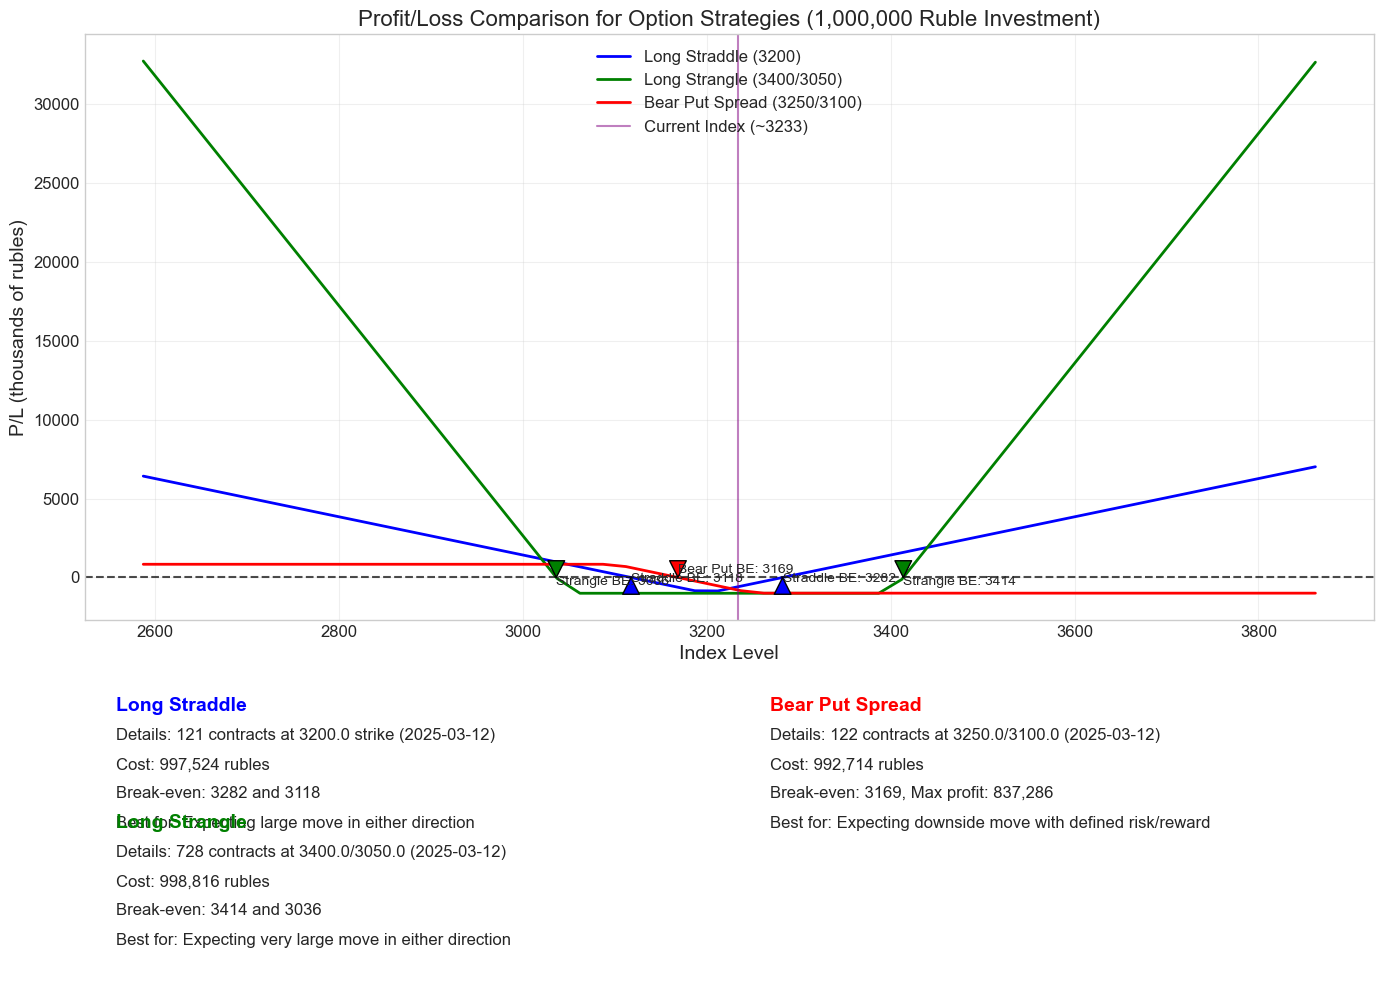

In [21]:
# Cell 7: Plot Strategy Comparison
def plot_strategy_comparison(strategy_results, avg_index_level):
    """
    Plot profit/loss diagrams for the recommended strategies
    """
    # Current index level
    current_index = avg_index_level
    
    # Find our recommended strategies
    straddle = None
    if strategy_results['straddles']:
        straddle = next((s for s in strategy_results['straddles'] 
                          if abs(s['strike'] - 3200) < 10), 
                         strategy_results['straddles'][0])
    
    strangle = next(iter(strategy_results['strangles']), None)
    bear_put = next(iter(strategy_results['bear_put_spreads']), None)
    
    if not all([straddle, strangle, bear_put]):
        print("Not all strategies are available for plotting")
        return
    
    # Range from -20% to +20% of current index
    min_index = np.floor(current_index * 0.8)
    max_index = np.ceil(current_index * 1.2)
    index_range = np.arange(min_index, max_index, 25)
    
    # Calculate P/L for different strategies across a range of prices
    straddle_pl = []
    strangle_pl = []
    bear_put_pl = []
    
    for i in index_range:
        # Straddle
        if straddle:
            if i > straddle['strike']:
                pl = ((i - straddle['strike']) * straddle['contracts'] * 100) - straddle['investment']
            else:
                pl = ((straddle['strike'] - i) * straddle['contracts'] * 100) - straddle['investment']
            straddle_pl.append(pl / 1000)  # Convert to thousands for better display
        
        # Strangle
        if strangle:
            if i > strangle['call_strike']:
                pl = ((i - strangle['call_strike']) * strangle['contracts'] * 100) - strangle['investment']
            elif i < strangle['put_strike']:
                pl = ((strangle['put_strike'] - i) * strangle['contracts'] * 100) - strangle['investment']
            else:
                pl = -strangle['investment']
            strangle_pl.append(pl / 1000)
        
        # Bear Put Spread
        if bear_put:
            if i >= bear_put['buy_strike']:
                pl = -bear_put['total_cost']
            elif i <= bear_put['sell_strike']:
                pl = bear_put['total_max_profit']
            else:
                pl = ((bear_put['buy_strike'] - i) * bear_put['contracts'] * 100) - bear_put['total_cost']
            bear_put_pl.append(pl / 1000)
    
    # Create the plot
    fig = plt.figure(figsize=(14, 10))
    gs = GridSpec(2, 2, height_ratios=[2, 1])
    
    # Main strategy comparison chart
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(index_range, straddle_pl, 'b-', linewidth=2, label=f"Long Straddle ({int(straddle['strike'])})")
    ax1.plot(index_range, strangle_pl, 'g-', linewidth=2, label=f"Long Strangle ({int(strangle['call_strike'])}/{int(strangle['put_strike'])})")
    ax1.plot(index_range, bear_put_pl, 'r-', linewidth=2, label=f"Bear Put Spread ({int(bear_put['buy_strike'])}/{int(bear_put['sell_strike'])})")
    
    # Add horizontal line at y=0 (break-even)
    ax1.axhline(y=0, color='black', linestyle='--', alpha=0.7)
    
    # Add vertical line at current index level
    ax1.axvline(x=current_index, color='purple', linestyle='-', alpha=0.5, label=f"Current Index (~{int(current_index)})")
    
    # Format the plot
    ax1.set_title('Profit/Loss Comparison for Option Strategies (1,000,000 Ruble Investment)', fontsize=16)
    ax1.set_xlabel('Index Level', fontsize=14)
    ax1.set_ylabel('P/L (thousands of rubles)', fontsize=14)
    ax1.legend(loc='best', fontsize=12)
    ax1.grid(True, alpha=0.3)
    
    # Add annotations for break-even points
    if straddle:
        ax1.annotate(f"Straddle BE: {straddle['break_even_down']:.0f}",
                    xy=(straddle['break_even_down'], 0), xytext=(straddle['break_even_down'], -300),
                    arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=10)
        ax1.annotate(f"Straddle BE: {straddle['break_even_up']:.0f}",
                    xy=(straddle['break_even_up'], 0), xytext=(straddle['break_even_up'], -300),
                    arrowprops=dict(facecolor='blue', shrink=0.05), fontsize=10)
    
    if strangle:
        ax1.annotate(f"Strangle BE: {strangle['break_even_down']:.0f}",
                    xy=(strangle['break_even_down'], 0), xytext=(strangle['break_even_down'], -500),
                    arrowprops=dict(facecolor='green', shrink=0.05), fontsize=10)
        ax1.annotate(f"Strangle BE: {strangle['break_even_up']:.0f}",
                    xy=(strangle['break_even_up'], 0), xytext=(strangle['break_even_up'], -500),
                    arrowprops=dict(facecolor='green', shrink=0.05), fontsize=10)
    
    if bear_put:
        ax1.annotate(f"Bear Put BE: {bear_put['break_even']:.0f}",
                    xy=(bear_put['break_even'], 0), xytext=(bear_put['break_even'], 300),
                    arrowprops=dict(facecolor='red', shrink=0.05), fontsize=10)
    
    # Strategy info panels
    strat_info = [
        {
            'title': 'Long Straddle',
            'color': 'blue',
            'data': [
                f"Details: {straddle['contracts']} contracts at {straddle['strike']} strike ({straddle['date'].date()})",
                f"Cost: {straddle['investment']:,.0f} rubles",
                f"Break-even: {straddle['break_even_up']:.0f} and {straddle['break_even_down']:.0f}",
                f"Best for: Expecting large move in either direction"
            ]
        },
        {
            'title': 'Long Strangle',
            'color': 'green',
            'data': [
                f"Details: {strangle['contracts']} contracts at {strangle['call_strike']}/{strangle['put_strike']} ({strangle['date'].date()})",
                f"Cost: {strangle['investment']:,.0f} rubles",
                f"Break-even: {strangle['break_even_up']:.0f} and {strangle['break_even_down']:.0f}",
                f"Best for: Expecting very large move in either direction"
            ]
        },
        {
            'title': 'Bear Put Spread',
            'color': 'red',
            'data': [
                f"Details: {bear_put['contracts']} contracts at {bear_put['buy_strike']}/{bear_put['sell_strike']} ({bear_put['date'].date()})",
                f"Cost: {bear_put['total_cost']:,.0f} rubles",
                f"Break-even: {bear_put['break_even']:.0f}, Max profit: {bear_put['total_max_profit']:,.0f}",
                f"Best for: Expecting downside move with defined risk/reward"
            ]
        }
    ]
    
    # Create info boxes
    ax2 = fig.add_subplot(gs[1, 0])
    ax3 = fig.add_subplot(gs[1, 1])
    
    # Hide axes for info boxes
    ax2.axis('off')
    ax3.axis('off')
    
    # Add strategy information text boxes
    props = dict(boxstyle='round', alpha=0.1)
    
    for i, info in enumerate(strat_info):
        if i <= 1:
            # First two strategies in first box
            ax2.text(0.05, 0.9 - i*0.4, info['title'], fontsize=14, color=info['color'], fontweight='bold')
            for j, line in enumerate(info['data']):
                ax2.text(0.05, 0.8 - i*0.4 - j*0.1, line, fontsize=12)
        else:
            # Third strategy in second box
            ax3.text(0.05, 0.9, info['title'], fontsize=14, color=info['color'], fontweight='bold')
            for j, line in enumerate(info['data']):
                ax3.text(0.05, 0.8 - j*0.1, line, fontsize=12)
    
    plt.tight_layout()
    plt.savefig('strategy_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot strategy comparison
plot_strategy_comparison(strategy_results, avg_index_level)

In [22]:
# Cell 8: Plot Lognormal Distribution
def plot_lognormal_distribution(df, mean, std_dev, log_mean, log_sigma):
    """
    Plot lognormal distribution of call prices
    """
    # Get call prices
    call_prices = df['CALL: Расчетная цена'].dropna()
    
    if call_prices.empty:
        print("No call price data available for lognormal analysis")
        return
    
    # Create x values for plotting
    x = np.linspace(max(0.1, mean - 3*std_dev), mean + 3*std_dev, 1000)
    pdf_lognormal = stats.lognorm.pdf(x, s=log_sigma, scale=np.exp(log_mean))
    
    # Create the plot
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot histogram of actual data
    ax.hist(call_prices, bins=30, density=True, alpha=0.6, color='skyblue', label='Actual Call Prices')
    
    # Plot lognormal distribution
    ax.plot(x, pdf_lognormal, 'r-', linewidth=2, label='Fitted Lognormal Distribution')
    
    # Add vertical lines for mean
    ax.axvline(x=mean, color='blue', linestyle='--', alpha=0.7, label=f'Mean Price: {mean:.2f}')
    
    # Add vertical lines for +/- 1 std dev
    ax.axvline(x=mean + std_dev, color='green', linestyle='--', alpha=0.5, label=f'Mean + 1σ: {mean+std_dev:.2f}')
    ax.axvline(x=mean - std_dev, color='green', linestyle='--', alpha=0.5, label=f'Mean - 1σ: {max(0, mean-std_dev):.2f}')
    
    # Format the plot
    ax.set_title('Lognormal Distribution of MOEX Call Prices', fontsize=16)
    ax.set_xlabel('Call Price', fontsize=14)
    ax.set_ylabel('Probability Density', fontsize=14)
    ax.legend(loc='best')
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('price_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot lognormal distribution
plot_lognormal_distribution(df, mean, std_dev, log_mean, log_sigma)

NameError: name 'mean' is not defined

In [ ]:
# Cell 9: Final Recommendations
print("\n=== FINAL RECOMMENDATION ===")
print("Based on the analysis, the following strategies are recommended:")

# Find the bear put spread with the best ROI
if strategy_results['bear_put_spreads']:
    best_bear_put = max(strategy_results['bear_put_spreads'], key=lambda x: x['roi'])
    print(f"\n1. BEAR PUT SPREAD (March {best_bear_put['date'].day}, 2025)")
    print(f"   Buy Put @ {best_bear_put['buy_strike']}, Sell Put @ {best_bear_put['sell_strike']}")
    print(f"   Cost: {best_bear_put['total_cost']:,.0f} rubles for {best_bear_put['contracts']} contracts")
    print(f"   Break-even: {best_bear_put['break_even']:.2f} ({best_bear_put['pct_move']:.2f}% move)")
    print(f"   Maximum profit: {best_bear_put['total_max_profit']:,.0f} rubles ({best_bear_put['roi']:.2f}% ROI)")
    print(f"   This strategy offers the best risk-reward ratio for expected downside movement.")

# Find the straddle with the smallest required move
if strategy_results['straddles']:
    best_straddle = min(strategy_results['straddles'], key=lambda x: min(x['pct_move_up'], x['pct_move_down']))
    print(f"\n2. LONG STRADDLE (March {best_straddle['date'].day}, 2025)")
    print(f"   Buy Call and Put @ {best_straddle['strike']} strike")
    print(f"   Cost: {best_straddle['investment']:,.0f} rubles for {best_straddle['contracts']} contracts")
    print(f"   Break-even Up: {best_straddle['break_even_up']:.2f} ({best_straddle['pct_move_up']:.2f}% move)")
    print(f"   Break-even Down: {best_straddle['break_even_down']:.2f} ({best_straddle['pct_move_down']:.2f}% move)")
    print(f"   This strategy provides unlimited profit potential in either direction with defined risk.")

# Find the strangle with the best leverage
if strategy_results['strangles']:
    best_strangle = max(strategy_results['strangles'], key=lambda x: x['contracts'])
    print(f"\n3. LONG STRANGLE (March {best_strangle['date'].day}, 2025)")
    print(f"   Buy OTM Call @ {best_strangle['call_strike']} and OTM Put @ {best_strangle['put_strike']}")
    print(f"   Cost: {best_strangle['investment']:,.0f} rubles for {best_strangle['contracts']} contracts")
    print(f"   Break-even Up: {best_strangle['break_even_up']:.2f} ({best_strangle['pct_move_up']:.2f}% move)")
    print(f"   Break-even Down: {best_strangle['break_even_down']:.2f} ({best_strangle['pct_move_down']:.2f}% move)")
    print(f"   This strategy offers maximum leverage for significant market moves.")

# Summarize key findings in a concise, easy-to-reference format
print("\n=== STRATEGY SUMMARY ===")
summary_data = []

if strategy_results['straddles']:
    summary_data.append({
        'Strategy': 'Long Straddle',
        'Strike(s)': f"{best_straddle['strike']}",
        'Break-even': f"{best_straddle['break_even_down']:.0f}/{best_straddle['break_even_up']:.0f}",
        'Contracts': best_straddle['contracts'],
        'Investment': f"{best_straddle['investment']:,.0f}",
        'Required Move': f"{min(best_straddle['pct_move_up'], best_straddle['pct_move_down']):.2f}%"
    })

if strategy_results['strangles']:
    summary_data.append({
        'Strategy': 'Long Strangle',
        'Strike(s)': f"{best_strangle['put_strike']}/{best_strangle['call_strike']}",
        'Break-even': f"{best_strangle['break_even_down']:.0f}/{best_strangle['break_even_up']:.0f}",
        'Contracts': best_strangle['contracts'],
        'Investment': f"{best_strangle['investment']:,.0f}",
        'Required Move': f"{min(best_strangle['pct_move_up'], best_strangle['pct_move_down']):.2f}%"
    })

if strategy_results['bear_put_spreads']:
    summary_data.append({
        'Strategy': 'Bear Put Spread',
        'Strike(s)': f"{best_bear_put['buy_strike']}/{best_bear_put['sell_strike']}",
        'Break-even': f"{best_bear_put['break_even']:.0f}",
        'Contracts': best_bear_put['contracts'],
        'Investment': f"{best_bear_put['total_cost']:,.0f}",
        'Required Move': f"{best_bear_put['pct_move']:.2f}%"
    })

# Display as DataFrame for easy comparison
pd.DataFrame(summary_data)

In [ ]:


# График 1: Историческая цена с сигналами покупки и продажи
plt.subplot(1, 2, 1)
plt.plot(df[date_ex], df[call_Settlement_price], label=call_Settlement_price, color='blue')
# Отображаем сигналы покупки и продажи
buy_signals = df[df['Сигнал'] == 'Покупка']
sell_signals = df[df['Сигнал'] == 'Продажа']
plt.scatter(buy_signals[date_ex], buy_signals[call_Settlement_price], marker='^', color='green', label='Покупка', s=100)
plt.scatter(sell_signals[date_ex], sell_signals[call_Settlement_price], marker='v', color='red', label='Продажа', s=100)
plt.xlabel(date_ex)
plt.ylabel(call_Settlement_price)
plt.title('Историческая цена и торговые сигналы')
plt.legend()

# График 2: Гистограмма распределения цены и подгонка логнормального распределения
plt.subplot(1, 2, 2)
plt.hist(df[call_Settlement_price], bins=20, density=True, alpha=0.6, label='Гистограмма цены', color='skyblue')
plt.plot(x, pdf_fitted, 'r-', lw=2, label='Логнормальное распределение')
plt.xlabel(call_Settlement_price)
plt.ylabel('Плотность распределения')
plt.title('Распределение цены')
plt.legend()

plt.tight_layout()
plt.show()

# Вычисление скользящего стандартного отклонения (20-дневная волатильность) ---
# этот показатель можно интерпретировать как оценку будущей волатильности.
df['Волатильность_20'] = df[call_Settlement_price].rolling(window=20).std()

# График скользящей волатильности
plt.figure(figsize=(10, 4))
plt.plot(df[date_ex], df['Волатильность_20'], label='20-дневная волатильность', color='purple')
plt.xlabel(date_ex)
plt.ylabel('Стандартное отклонение')
plt.title('Будущая волатильность (20-дневное скользящее стандартное отклонение)')
plt.legend()
plt.show()